In [1]:
from pathlib import Path
import os

if __name__ == "__main__":
    current_path = Path.cwd()

    parent_dir = current_path.parent

    os.chdir(parent_dir)

# Importing our Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import onnx as nx
import onnxruntime as ort

# Importing our data

In [3]:
df_train = pd.read_csv(r'Dataset\train.csv')

df_test = pd.read_csv(r'Dataset\test.csv')

# EDA

## Data info

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Titanic Dataset Feature Descriptions

| **Feature**     |                                                 **Description**                                                |
|-----------------|----------------------------------------------------------------------------------------------------------------|
| `PassengerId`   | A unique identifier for each passenger.                                                                        |
| `Survived`      | Survival status (**target variable**): <br> `0` = Did not survive, `1` = Survived.                             |
| `Pclass`        | Ticket class (proxy for socio-economic status): <br> `1` = First class, `2` = Second class, `3` = Third class. |
| `Name`          | Full name of the passenger.                                                                                    |
| `Sex`           | Gender of the passenger: `male` or `female`.                                                                   |
| `Age`           | Age in years.                                                                                                  |
| `SibSp`         | Number of siblings or spouses aboard the Titanic. Indicates family relationships.                              |
| `Parch`         | Number of parents or children aboard.                                                                          |
| `Ticket`        | Ticket number.                                                                                                 |
| `Fare`          | Amount paid for the ticket.                                                                                    |
| `Cabin`         | Cabin number. First letter indicates deck, which may have predictive value.                                    |
| `Embarked`      | Port of embarkation: <br> `C` = Cherbourg, `Q` = Queenstown, `S` = Southampton.                                |


## Data Shape

In [6]:
df_train.shape

(891, 12)

## Null values

In [7]:
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Duplicate values

In [8]:
df_train.duplicated().sum()

np.int64(0)

## Survivability diagrams

### Per Sex

<Axes: xlabel='Sex', ylabel='Survived'>

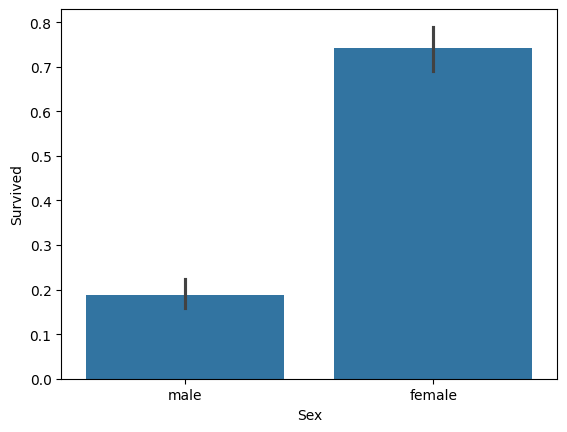

In [9]:
sns.barplot(x='Sex', y='Survived', data=df_train)

### Per Age

<Axes: xlabel='Survived', ylabel='Age'>

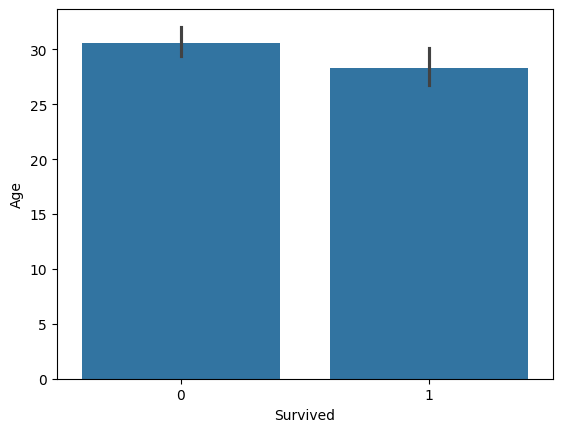

In [10]:
sns.barplot(x='Survived', y='Age', data=df_train)

# Data Preprocessing

## Dropping unnecessary features

In [11]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [13]:
df_train.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

## Filling the null values

In [14]:
df_train["Age"] = df_train["Age"].fillna(df_train["Age"].mean())
df_train["Embarked"] = df_train["Embarked"].fillna(df_train["Embarked"].mode()[0])
df_train.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

## Encoding our Categorical features

In [15]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [16]:
categorical_cols = df_train.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


## Spliting our data

In [17]:
X = df_train.drop(columns=['Survived'])
y = df_train['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Scaling our data

In [18]:
ss = MinMaxScaler()

scale_features_train = X_train[['Age', 'Fare']]
scale_features_val = X_val[['Age', 'Fare']]

X_train[['Age', 'Fare']] = ss.fit_transform(scale_features_train)
X_val[['Age', 'Fare']] = ss.transform(scale_features_val)

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
331,1,1,0.566474,0,0,0.055628,2
733,2,1,0.283740,0,0,0.025374,2
382,3,1,0.396833,0,0,0.015469,2
704,3,1,0.321438,1,0,0.015330,2
813,3,0,0.070118,4,2,0.061045,2


In [19]:
X_val.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
709,3,1,0.367921,1,1,0.029758,0
439,2,1,0.384267,0,0,0.020495,2
840,3,1,0.246042,0,0,0.015469,2
720,2,0,0.070118,0,1,0.064412,2
39,3,0,0.170646,1,0,0.021942,0


# Intializing our Tensordataset and DataLoader

## Changing our data to tensors `Compatible format for neural network model training`

In [20]:
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

## Creating our TensorDatasets

In [21]:
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

## Creating our Dataloader

In [22]:
train_dataloader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=16, shuffle=False)

# DNN Model Intialization

In [23]:
class TitanicDNN(nn.Module):
    def __init__(self):
        super(TitanicDNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(X_train.shape[1], 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TitanicDNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Model Training

In [ ]:
epochs = 100

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    # Loop through training batches
    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()              # Reset gradients
        outputs = model(x)                 # Forward pass
        loss = criterion(outputs, y)       # Calculate loss
        loss.backward()                    # Backward pass
        optimizer.step()                   # Update weights

        train_loss += loss.item() * x.size(0)  

        # Accuracy: convert logits to binary prediction (0 or 1)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_correct += (preds == y).sum().item()  
        total_train += y.size(0)                    

    train_loss /= len(train_dataloader.dataset)     # Average train loss
    train_acc = train_correct / total_train         # Training accuracy

    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        for x, y in val_dataloader:
            x, y = x.to(device), y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item() * x.size(0)

            # Accuracy: convert logits to binary prediction (0 or 1)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == y).sum().item()
            total_val += y.size(0)

    val_loss /= len(val_dataloader.dataset)         # Average val loss
    val_acc = val_correct / total_val               # Validation accuracy

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


Epoch 1, Train Loss: 0.6667, Train Acc: 0.6081, Val Loss: 0.5927, Val Acc: 0.7318
Epoch 2, Train Loss: 0.5763, Train Acc: 0.7430, Val Loss: 0.5323, Val Acc: 0.7765
Epoch 3, Train Loss: 0.5371, Train Acc: 0.7795, Val Loss: 0.4778, Val Acc: 0.7933
Epoch 4, Train Loss: 0.4929, Train Acc: 0.8006, Val Loss: 0.4595, Val Acc: 0.8101
Epoch 5, Train Loss: 0.5011, Train Acc: 0.7949, Val Loss: 0.4525, Val Acc: 0.8101
Epoch 6, Train Loss: 0.4815, Train Acc: 0.7935, Val Loss: 0.4400, Val Acc: 0.8156
Epoch 7, Train Loss: 0.4769, Train Acc: 0.7921, Val Loss: 0.4347, Val Acc: 0.8045
Epoch 8, Train Loss: 0.4783, Train Acc: 0.8062, Val Loss: 0.4337, Val Acc: 0.8101
Epoch 9, Train Loss: 0.4817, Train Acc: 0.7921, Val Loss: 0.4340, Val Acc: 0.8101
Epoch 10, Train Loss: 0.4836, Train Acc: 0.7949, Val Loss: 0.4276, Val Acc: 0.8101
Epoch 11, Train Loss: 0.4703, Train Acc: 0.8132, Val Loss: 0.4270, Val Acc: 0.8101
Epoch 12, Train Loss: 0.4665, Train Acc: 0.8062, Val Loss: 0.4237, Val Acc: 0.8268
Epoch 13, Tra

# Saving our model in an onnx compatible format

In [27]:
model.eval()
sample_input = torch.randn(1, X_train.shape[1]).to(device)

In [28]:
torch.onnx.export(
    model,                      # your model
    sample_input,               # dummy input
    "models/titanic_model.onnx",# output file
    export_params=True,         # store the trained weights
    opset_version=11,           # ONNX version (11 is widely supported)
    do_constant_folding=True,   # optimize constants
    input_names=['input'],      # name of model input
    output_names=['output'],    # name of model output
    dynamic_axes={              # support variable batch size
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)
